In [1]:
library(lme4)
options(rgl.useNULL=TRUE)
library(LMERConvenienceFunctions)

library(ggplot2)
options(jupyter.plot_mimetypes = 'image/png')
library(repr)
options(repr.plot.width=6, repr.plot.height=6)

library(car)
library(MASS)

library(vcd)

Loading required package: Matrix
Loading required package: grid


# Body length

In this notebook, we document our various steps taken to study the effect of the course of a session on the body length (number of characters). Note that we only do this on a sample of 1 mio. data points here.

In [103]:
#no zeros in the outcome variable
data = read.csv("/home/psinger/Reddit-depletion/data/sample.csv", header=TRUE)

In [3]:
nrow(data)

[1] 1000000

We can limit our data to those sessions that have at least two comments.

In [104]:
idx = data$session_comments > 1
data = data[idx,]

In [21]:
nrow(data)

[1] 667938

## Data inspection

We start by getting a better feeling of our data. Note that body_length represents count data.

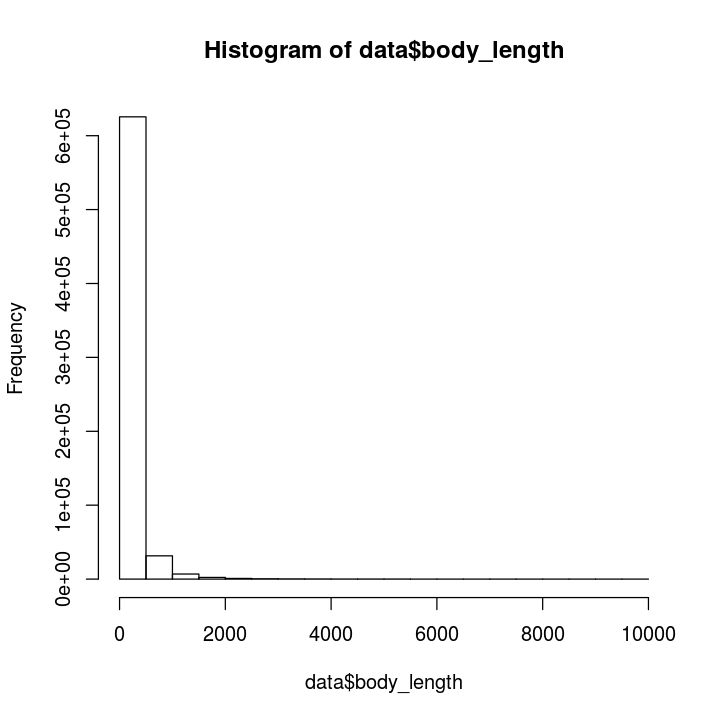

In [7]:
hist(data$body_length)

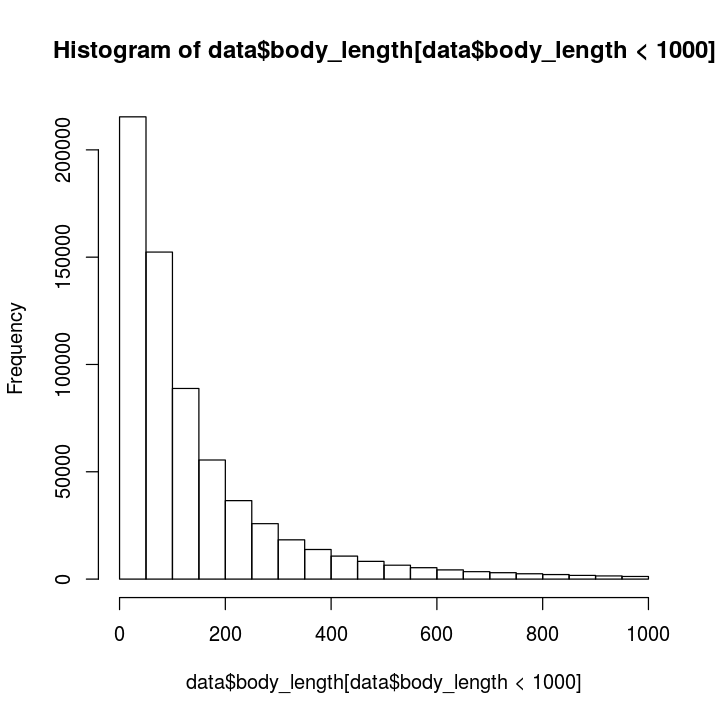

In [8]:
hist(data$body_length[data$body_length<1000])

## Regression model

We use mixed-effects models where in the most basic form (that we analyze in this notebook), we are interested in studying body_length ~ 1 + session_index + (1|session_comments) + (1|author).

### Linear mixed-effects regression

Even though we cannot expect a simple linear mixed-effects regression to be an appropriate model for our count data, we start with it.

In [39]:
m_lmer = lmer(body_length~1+session_index+session_comments+(1|author), data=data, REML=FALSE)

In [40]:
summary(m_lmer)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: body_length ~ 1 + session_index + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 9352265  9352322 -4676128  9352255   667933 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-5.842 -0.405 -0.230  0.085 36.358 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 13035    114.2   
 Residual             60283    245.5   
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                  Estimate Std. Error t value
(Intercept)      172.18410    0.41904   410.9
session_index     -0.23151    0.04072    -5.7
session_comments  -0.13633    0.02751    -5.0

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.039       
sssn_cmmnts -0.177 -0.759

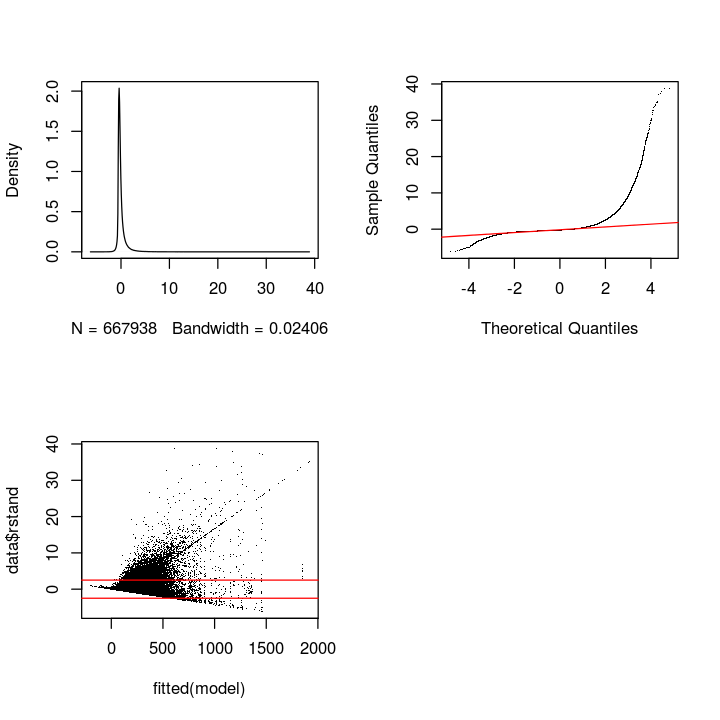

In [41]:
mcp.fnc(m_lmer)

What we can see in above plot is, that the residuals do not appear to be normally distributed and we can see clear heteroskedasticity. Thus, as expected, a linear model does not provide a good fit here.

### Linear mixed-effects regression (log-transform)

Next, let us take the log of the response variable and repeat a linear regression.

In [42]:
m_lmer_log = lmer(log(body_length)~1+session_index+session_comments+(1|author), data=data, REML=FALSE)

In [55]:
summary(m_lmer_log)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_index + session_comments + (1 |  
    author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 2120743  2120800 -1060367  2120733   667933 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0147 -0.5592  0.0370  0.6060  4.3117 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3474   0.5894  
 Residual             1.1423   1.0688  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       4.4599144  0.0019309  2309.8
session_index    -0.0011932  0.0001777    -6.7
session_comments -0.0011496  0.0001213    -9.5

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.037       
sssn_cmmnts -0.168 -0.751

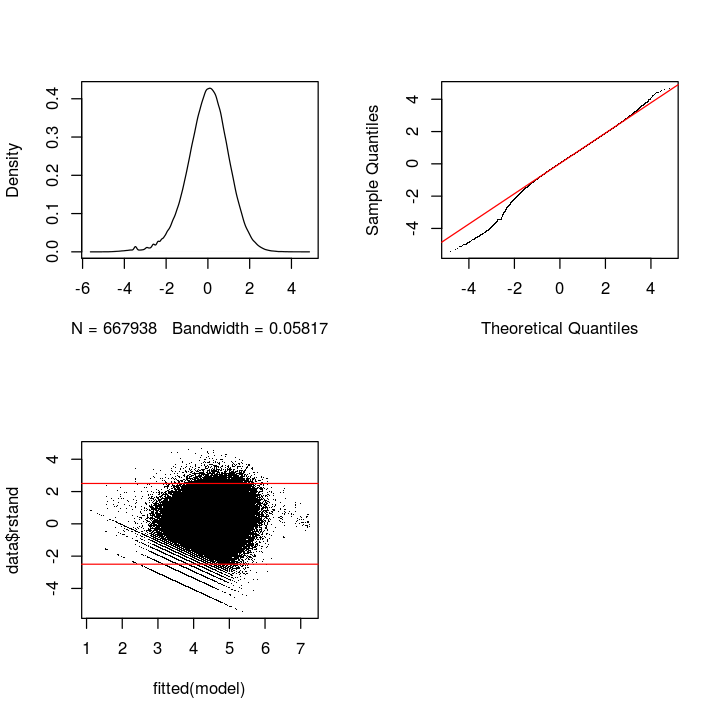

In [44]:
mcp.fnc(m_lmer_log)

That looks pretty good already. For completeness, we proceed by looking at generalized linear mixed-effects models though as they usually capture count data quite well.

### Poisson GLMER

Let us start with a Poisson GLMER, which is a main choice when working with count data.

In [45]:
m_poisson = glmer(body_length~1+session_index+session_comments+(1|author),data=data,family=poisson())

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.0841476 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

In [48]:
summary(m_poisson)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: body_length ~ 1 + session_index + session_comments + (1 | author)
   Data: data

      AIC       BIC    logLik  deviance  df.resid 
 58129830  58129875 -29064911  58129822    667934 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-61.51  -4.38  -0.10   1.41 327.85 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 1.166    1.08    
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       4.593e+00  1.968e-03  2333.3   <2e-16 ***
session_index    -2.036e-03  1.763e-05  -115.5   <2e-16 ***
session_comments  2.867e-04  1.198e-05    23.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.006       
sssn_cmmnts -0.014 -0.690
convergence code: 0
Mode

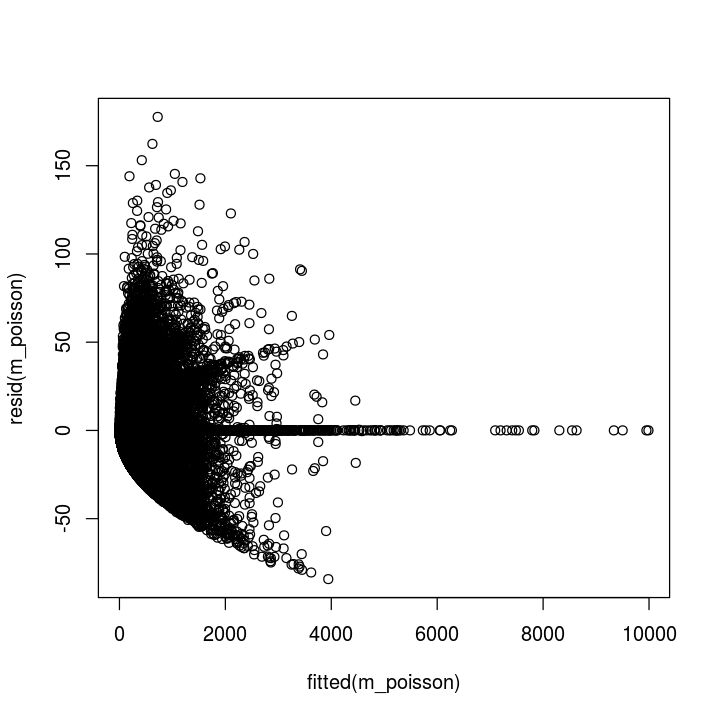

In [49]:
plot(fitted(m_poisson),resid(m_poisson))

The convergence message shows low magnitude and for such large data this might be a false positive as emphasized in the lme4 docu. 

The residual plots for generalized linear models are generally quite difficult to interpret as the residuals do not necessarily need to follow a normal distribution any longer. However, the fitted vs. residual plots shows a typical pattern for Poisson regression with curvilinear traces. What we can do though as a first step here, is to look at overdispersion (see http://glmm.wikidot.com/faq).

In [50]:
overdisp_fun <- function(model) {
  ## number of variance parameters in 
  ##   an n-by-n variance-covariance matrix
  vpars <- function(m) {
    nrow(m)*(nrow(m)+1)/2
  }
  model.df <- sum(sapply(VarCorr(model),vpars))+length(fixef(model))
  rdf <- nrow(model.frame(model))-model.df
  rp <- residuals(model,type="pearson")
  Pearson.chisq <- sum(rp^2)
  prat <- Pearson.chisq/rdf
  pval <- pchisq(Pearson.chisq, df=rdf, lower.tail=FALSE)
  c(chisq=Pearson.chisq,ratio=prat,rdf=rdf,p=pval)
}

In [56]:
overdisp_fun(m_poisson)

chisq        ratio          rdf            p 
5.943269e+07 8.897988e+01 6.679340e+05 0.000000e+00

As expected, we have to deal with overdispersion. There are generally some ways of doing so: (i) adding an individual-level random effect or (ii) using a negative binomial model or (iii) using quasi likelihood. Let us start with the first option.

In [52]:
data$obs<-factor(seq.int(nrow(data)))
m_poisson2 = glmer(body_length~1+session_index+session_comments+(1|author)+(1|obs),data=data,family=poisson())

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00212814 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

In [53]:
summary(m_poisson2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: body_length ~ 1 + session_index + session_comments + (1 | author) +  
    (1 | obs)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 8026058  8026115 -4013024  8026048   667933 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.71382 -0.08758  0.00220  0.04255  0.27962 

Random effects:
 Groups Name        Variance Std.Dev.
 obs    (Intercept) 1.053    1.0263  
 author (Intercept) 0.341    0.5839  
Number of obs: 667938, groups:  obs, 667938; author, 304105

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       4.4765540  0.0018885  2370.4  < 2e-16 ***
session_index    -0.0011818  0.0001738    -6.8 1.04e-11 ***
session_comments -0.0011372  0.0001187    -9.6  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sssn

In [54]:
overdisp_fun(m_poisson2)

chisq        ratio          rdf            p 
2.594513e+04 3.884391e-02 6.679330e+05 1.000000e+00

Great, the overdispersion problem is gone. The results (coefficients) are very similar to the previous models though (specifically to the log-normal).

For completeness, we also want to utilize a negative binomial family though by first using the nb functionality provided in lme4.

In [ ]:
m_nb = glmer.nb(body_length~1+session_index+session_comments+(1|author),data=data)

In [ ]:
summary(m_nb)

We end up with multiple convergence warnings (not shown); the coefficients are quite similar to our previous observations though. Note that this model also takes a very long time to fit for this sample of 1 mio. data points; it does not really scale for larger data which in our case consists of more than 50 mio. data points.

As a consequence, let us next also fit a negative binomial regression, but this time we use quasi likelihood.

In [61]:
#just for initialization
init = glm.nb(body_length~1+session_index+session_comments,data=data)

Warning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: 

In [62]:
init$theta

[1] 0.8608633

In [63]:
m_pql_nb = glmmPQL(body_length~1+session_index+session_comments, random = list(~1 | author), data = data, family = negative.binomial(theta=init$theta))

Warning message:
: glm.fit: algorithm did not convergeiteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


In [65]:
summary(m_pql_nb)

Linear mixed-effects model fit by maximum likelihood
 Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | author
        (Intercept)  Residual
StdDev:   0.5482621 0.8984701

Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects: body_length ~ 1 + session_index + session_comments 
                     Value    Std.Error     DF   t-value p-value
(Intercept)       4.849413 0.0017709901 363831 2738.2496       0
session_index    -0.001010 0.0001628222 363831   -6.2058       0
session_comments -0.001187 0.0001109941 363831  -10.6930       0
 Correlation: 
                 (Intr) sssn_n
session_index    -0.038       
session_comments -0.166 -0.751

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3        Max 
-1.6881893 -0.6398241 -0.2622422  0.3558993 24.3218879 

Number of Observations: 667938
Number of Groups: 304105 

Again, similar results (even though we receive some convergence warnings).

## Final model choice

Given our extensive analysis regarding the appropriate model for our data, we conclude that regardless of our model choice, the coefficients and subsequent inference are very similar. Nonetheless, we will proceed with a linear model on the log-transformed body_length due to the appropriate diagnostic plots, the simplicity of the model and the high mean of body_length.

## Significance of effects

Now that we have decided on a model, we want to extend our inference. First, we want to study the significance of the fixed effects as well as potential additional random effects. 

There are several options for determining the significance of a fixed effect on the model. For example, a common approach is to use the ratio of the slope to its standard error and then use a t-test for determining its significance. Alternatively, one can also use F-tests for contrasting simpler to more complex models. Both methods require a specification of the degrees of freedom though which is not trivial in mixed models; methods such as the Satterthwaite approximation or Kenward-Roger approximation can be used for that task. 
As stated in Baayen 2008, we can also directly use the t-statistics given to derive statistical significance. Because we have a huge dataset, a t-statistic above 2 can be regarded as significant at the 5\% level in a two-tailed test. You can derive this directly from the results above.

However, here, we follow an approach used for comparing models: the Bayesian Information Criterion (alternatively we could also work with AIC or LRT). Basically, the idea is to specify different (in this case nested) models that successively incorporate additional fixed or random effects and then compare their BIC scores. The lower the BIC, the better a model is (above a small threshold).

The baseline model we start with is:

body_length = 1 + (1|author)

The reason why we incorporate the random effect for author from the beginning is that this is necessary based on the design of the experiment. Also, as pointed out in http://glmm.wikidot.com/faq, you should not compare the fit of a (g)lmer with one from a (g)lm.

Okay, so let us get the BIC for the baseline model.

In [66]:
m1 = lmer(log(body_length)~1+(1|author), data = data, REML=FALSE)

In [67]:
summary(m1)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 2121266  2121301 -1060630  2121260   667935 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0094 -0.5606  0.0379  0.6058  4.2584 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3514   0.5928  
 Residual             1.1410   1.0682  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
            Estimate Std. Error t value
(Intercept) 4.446887   0.001846    2408

Next, let us incorporate the index and session length individually.

In [68]:
m2 = lmer(log(body_length)~1+session_index+(1|author), data = data, REML=FALSE)

In [69]:
summary(m2)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_index + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 2120831  2120877 -1060412  2120823   667934 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0148 -0.5596  0.0370  0.6057  4.3008 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3485   0.5903  
 Residual             1.1418   1.0686  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                Estimate Std. Error t value
(Intercept)    4.4568402  0.0019043  2340.4
session_index -0.0024562  0.0001173   -20.9

Correlation of Fixed Effects:
            (Intr)
session_ndx -0.250

In [86]:
m3 = lmer(log(body_length)~1+session_comments+(1|author), data = data, REML=FALSE)
summary(m3)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 2120786  2120832 -1060389  2120778   667934 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0134 -0.5591  0.0370  0.6060  4.2935 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3474   0.5894  
 Residual             1.1424   1.0688  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       4.459e+00  1.930e-03    2311
session_comments -1.762e-03  8.006e-05     -22

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.297

Based on the lower BIC we can clearly see that the incorporation of the session_index and session_comments (separately) improve our model, thus, we make inference on it (also the t-value indicates high significance).

In [70]:
m4 = lmer(log(body_length)~1+session_index+session_comments+(1|author), data = data, REML=FALSE)

In [71]:
summary(m4)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_index + session_comments + (1 |  
    author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 2120743  2120800 -1060367  2120733   667933 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0147 -0.5592  0.0370  0.6060  4.3117 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3474   0.5894  
 Residual             1.1423   1.0688  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       4.4599144  0.0019309  2309.8
session_index    -0.0011932  0.0001777    -6.7
session_comments -0.0011496  0.0001213    -9.5

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.037       
sssn_cmmnts -0.168 -0.751

As expected based on our initial empirical analysis in the paper, both the session index and session length are important effect to incorporate.

We stop at this point as our scope of interest is covered. However, one can arbitrarily extend the existing model.
For example, one might also argue that it is necessary to incorporate a random effect for the intercept based on different subreddits.

In [72]:
m5 = lmer(log(body_length)~1+session_index+session_comments+(1|author)+(1|subreddit), data = data, REML=FALSE)

In [73]:
summary(m5)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_index + session_comments + (1 |  
    author) + (1 | subreddit)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 2070695  2070763 -1035342  2070683   667932 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1447 -0.5598  0.0444  0.6147  4.5307 

Random effects:
 Groups    Name        Variance Std.Dev.
 author    (Intercept) 0.2109   0.4592  
 subreddit (Intercept) 0.2490   0.4990  
 Residual              1.1087   1.0530  
Number of obs: 667938, groups:  author, 304105; subreddit, 12571

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       4.5001195  0.0067523   666.5
session_index    -0.0012242  0.0001747    -7.0
session_comments -0.0001808  0.0001188    -1.5

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.010       
sssn_cmmnts -0.035 -0.754

Again, the BIC shows an improvement in the model. Yet, the inference on the fixed index effect does not change. For complexity reasons, we neglect the random effect for the subreddit for the complete data.

### Outliers

We also want to check for robustness when removing outliers.

In [74]:
data_limit <- romr.fnc(m3, data, trim = 2.5)$data

n.removed = 12216 
percent.removed = 1.828912 


In [75]:
m4_limit = lmer(log(body_length)~1+session_index+session_comments+(1|author),data=data_limit, REML=FALSE)

In [76]:
summary(m4_limit)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_index + session_comments + (1 |  
    author)
   Data: data_limit

      AIC       BIC    logLik  deviance  df.resid 
1966893.0 1966950.0 -983441.5 1966883.0    655717 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.10927 -0.60102  0.02009  0.61962  2.88984 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3639   0.6032  
 Residual             0.9158   0.9570  
Number of obs: 655722, groups:  author, 301562

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       4.4958098  0.0018317  2454.5
session_index    -0.0010018  0.0001605    -6.2
session_comments -0.0011192  0.0001104   -10.1

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.036       
sssn_cmmnts -0.160 -0.745

Not much changed.

### Collinearity

We also want to check for multicollinearity in our model; some explanations and code for checking that in lme4 is provided in https://hlplab.wordpress.com/2011/02/24/diagnosing-collinearity-in-lme4/.

In [77]:
source("mer-utils.R")
kappa.mer(m4)
max(vif.mer(m4))

[1] 4.502499

[1] 2.320024

Both the condition number and VIF show no reasons to be concerned about collinearity in this model.

### REML

Until now, we have fitted the models using ML as this allowed us to compare models with each other. To be sure regarding the consistency of our coefficient estimations, we will now also quickly fit the model with REML.

In [78]:
m4_reml = lmer(log(body_length)~1+session_index+session_comments+(1|author), data = data, REML=TRUE)

In [79]:
summary(m4_reml)

Linear mixed model fit by REML ['lmerMod']
Formula: log(body_length) ~ 1 + session_index + session_comments + (1 |  
    author)
   Data: data

REML criterion at convergence: 2120777

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0147 -0.5592  0.0370  0.6060  4.3117 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3474   0.5894  
 Residual             1.1423   1.0688  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       4.4599144  0.0019309  2309.8
session_index    -0.0011932  0.0001777    -6.7
session_comments -0.0011496  0.0001213    -9.5

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.037       
sssn_cmmnts -0.168 -0.751

The results are exactly the same.

### Length as random effect

We have decided to incorporate the variation between different session lengths as a controlling covariate, however we might also incorporate it as a controlling random effect.

In [80]:
m4_control = lmer(log(body_length)~1+session_index+(1|session_comments)+(1|author), data = data, REML=TRUE)

In [81]:
summary(m4_control)

Linear mixed model fit by REML ['lmerMod']
Formula: log(body_length) ~ 1 + session_index + (1 | session_comments) +  
    (1 | author)
   Data: data

REML criterion at convergence: 2120380

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0455 -0.5591  0.0368  0.6065  4.3309 

Random effects:
 Groups           Name        Variance Std.Dev.
 author           (Intercept) 0.345406 0.58771 
 session_comments (Intercept) 0.005562 0.07458 
 Residual                     1.142319 1.06879 
Number of obs: 667938, groups:  author, 304105; session_comments, 328

Fixed effects:
                Estimate Std. Error t value
(Intercept)    4.3536375  0.0096932   449.1
session_index -0.0015241  0.0001344   -11.3

Correlation of Fixed Effects:
            (Intr)
session_ndx -0.431

The results are similar.

## Randomized baseline data

In order to finally confirm our intuition and inference on the negative effect of the session index on the text length, we also study our randomized baseline data. We basically have two different randomized datasets: (i) new sessions based on randomized time differences and (ii) randomized positions inside existing sessions.

### Randomized sessions (time differences)

In [96]:
idx = data$session_comments_random > 1
data_random = data[idx,]

In [97]:
m1_random = lmer(log(body_length)~1+(1|author), data = data_random, REML=FALSE)
summary(m1_random)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + (1 | author)
   Data: data_random

      AIC       BIC    logLik  deviance  df.resid 
1687459.4 1687493.0 -843726.7 1687453.4    532363 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0252 -0.5572  0.0366  0.6060  4.1349 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3572   0.5977  
 Residual             1.1350   1.0654  
Number of obs: 532366, groups:  author, 231496

Fixed effects:
            Estimate Std. Error t value
(Intercept) 4.443965   0.002104    2113

In [98]:
m2_random = lmer(log(body_length)~1+session_index_random+(1|author), data = data_random, REML=FALSE)
summary(m2_random)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_index_random + (1 | author)
   Data: data_random

      AIC       BIC    logLik  deviance  df.resid 
1687425.9 1687470.6 -843708.9 1687417.9    532362 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0210 -0.5583  0.0366  0.6055  4.1304 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3567   0.5972  
 Residual             1.1352   1.0655  
Number of obs: 532366, groups:  author, 231496

Fixed effects:
                       Estimate Std. Error t value
(Intercept)           4.4476267  0.0021912    2030
session_index_random -0.0011157  0.0001871      -6

Correlation of Fixed Effects:
            (Intr)
sssn_ndx_rn -0.281

In [99]:
m3_random = lmer(log(body_length)~1+session_comments_random+(1|author), data = data_random, REML=FALSE)
summary(m3_random)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_comments_random + (1 | author)
   Data: data_random

      AIC       BIC    logLik  deviance  df.resid 
1687383.9 1687428.6 -843687.9 1687375.9    532362 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0167 -0.5586  0.0369  0.6054  4.2066 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.356    0.5966  
 Residual             1.136    1.0656  
Number of obs: 532366, groups:  author, 231496

Fixed effects:
                         Estimate Std. Error t value
(Intercept)              4.450491   0.002230  1996.1
session_comments_random -0.001172   0.000133    -8.8

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnt_ -0.333

In [100]:
m4_random = lmer(log(body_length)~1+session_index_random+session_comments_random+(1|author), data = data_random, REML=FALSE)
summary(m4_random)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: 
log(body_length) ~ 1 + session_index_random + session_comments_random +  
    (1 | author)
   Data: data_random

      AIC       BIC    logLik  deviance  df.resid 
1687384.6 1687440.5 -843687.3 1687374.6    532361 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0166 -0.5586  0.0368  0.6053  4.2209 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3559   0.5966  
 Residual             1.1355   1.0656  
Number of obs: 532366, groups:  author, 231496

Fixed effects:
                          Estimate Std. Error t value
(Intercept)              4.4504024  0.0022309  1994.9
session_index_random     0.0003258  0.0002881     1.1
session_comments_random -0.0013488  0.0002049    -6.6

Correlation of Fixed Effects:
            (Intr) sssn_n_
sssn_ndx_rn -0.035        
sssn_cmmnt_ -0.189 -0.761 

When comparing m3_random and m4_random, we can see now is that the incorporation of the session index is not improving the model in terms of the BIC score  and is thus, not significant (also has a low t-value < 2). 

The reason why the session length itself is still significant can be explained by our very conservative randomization method that just randomizes the time differences between comments before sessionizing and thus, still keeps many sessions intact.

### Randomized indexes

In [109]:
m3_random_2 = lmer(log(body_length)~1+session_comments+(1|author), data = data, REML=FALSE)
summary(m3_random_2)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 2124250  2124296 -1062121  2124242   669015 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9249 -0.5588  0.0391  0.6092  5.2432 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3495   0.5912  
 Residual             1.1413   1.0683  
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       4.4584835  0.0019343  2304.9
session_comments -0.0019029  0.0000821   -23.2

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.303

In [110]:
m4_random_2 = lmer(log(body_length)~1+session_index_random_2+session_comments+(1|author), data = data, REML=FALSE)
summary(m4_random_2)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_index_random_2 + session_comments +  
    (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 2124252  2124309 -1062121  2124242   669014 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9248 -0.5588  0.0390  0.6092  5.2435 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3495   0.5912  
 Residual             1.1413   1.0683  
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                         Estimate Std. Error t value
(Intercept)             4.458e+00  1.936e-03  2302.8
session_index_random_2  7.683e-05  1.798e-04     0.4
session_comments       -1.942e-03  1.224e-04   -15.9

Correlation of Fixed Effects:
            (Intr) ss___2
sssn_ndx__2 -0.043       
sssn_cmmnts -0.171 -0.742

Again, we see similar behavior, the incorporation of the random session index does not improve the model compared to one that already includes the session length.

Overall, the analyses presented in this notebook have demonstrated that the course of a session has a (negative) effect on the number of answers a post receives.